# CarND-Vehicle-Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import numpy as np

from glob import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from ipywidgets import interact
from os import listdir

import pickle
from scipy.ndimage.measurements import label

from math import sqrt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('done')

done


## Dataset exploration
Before we get on to extracting HOG features and training a classifier, let's explore the dataset a bit before deciding what features to use: combination of color and gradient features.

Cars: 8792
Not cars: 8968


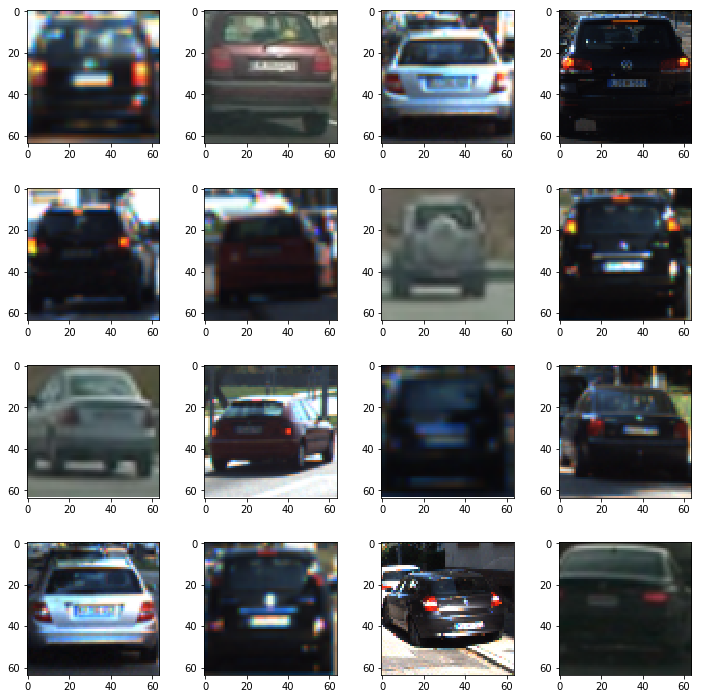

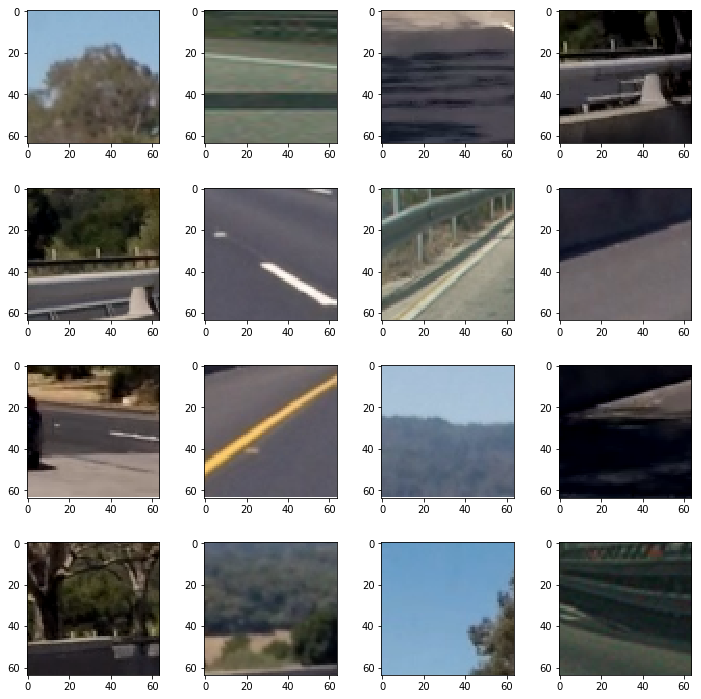

done


In [2]:
def displayImages(imglist, cols=1):
    # imglist items will have the format [img, label, cmap]
    count = len(imglist)
    rows = int(count/cols)
    f, (ax) = plt.subplots(cols, rows, figsize=(10, 10))
    f.tight_layout()
    ax = ax.ravel()
    for i in range(count):
        img = cv2.imread(imglist[i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
    plt.show()


path_vehicles = 'datasets/vehicles/'
path_non_vehicles = 'datasets/non-vehicles/'

cars = glob(path_vehicles + '**/*.png')
notcars = glob(path_non_vehicles + '**/*.png')

print('Cars:', len(cars))
print('Not cars:', len(notcars))

cars_shuffled = shuffle(cars)
not_cars_shuffled = shuffle(notcars)

displayImages(cars_shuffled[:16], 4)
displayImages(not_cars_shuffled[:16], 4)

print('done')

## Features extraction

We will start exploring the color spaces with test images.

In [3]:
def displayColorSpace(img, ch1Label, ch2Label, ch3Label):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
    ax1.imshow(img[:,:,0], cmap='gray')
    ax1.set_title(ch1Label, fontsize=15)
    ax2.imshow(img[:,:,1], cmap='gray')
    ax2.set_title(ch2Label, fontsize=15)
    ax3.imshow(img[:,:,2], cmap='gray')
    ax3.set_title(ch3Label, fontsize=15)
    f.tight_layout()
    plt.show()

def displayAllColorSpaces(img):
    displayColorSpace(img, 'R', 'G', 'B')
    displayColorSpace(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), 'H', 'S', 'V')
    displayColorSpace(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb), 'Y', 'Cr', 'Cb')
    
print('done')

done


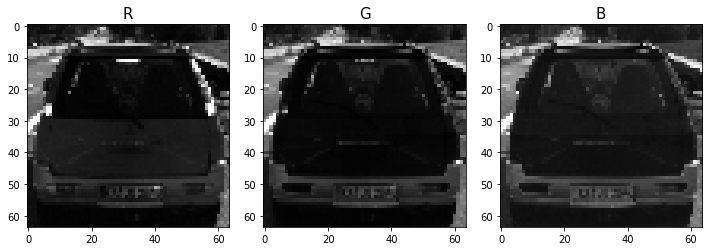

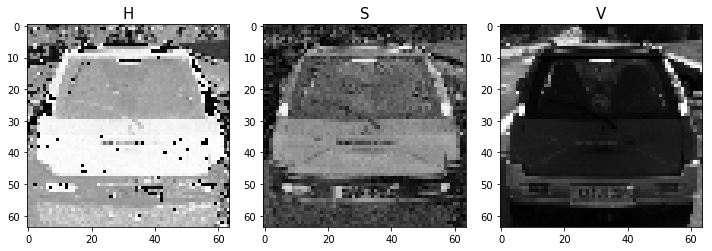

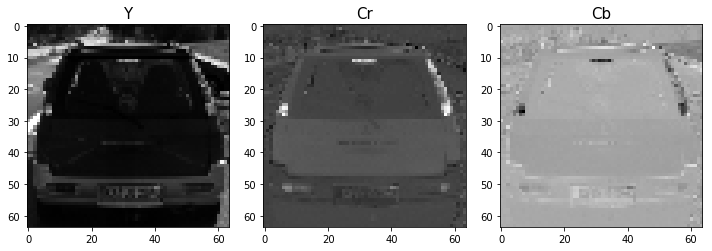

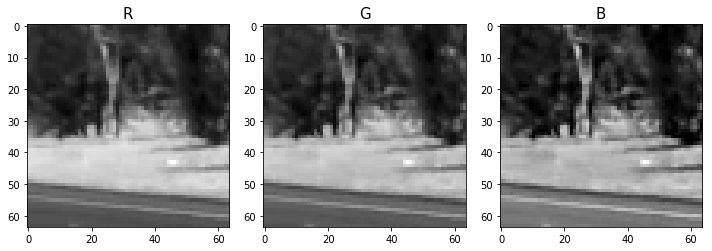

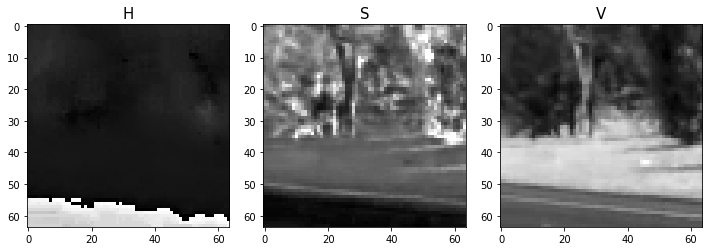

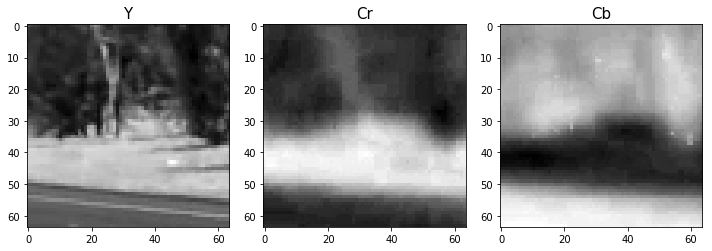

done


In [4]:
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
displayAllColorSpaces(image)

ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
displayAllColorSpaces(image)

print('done')

done


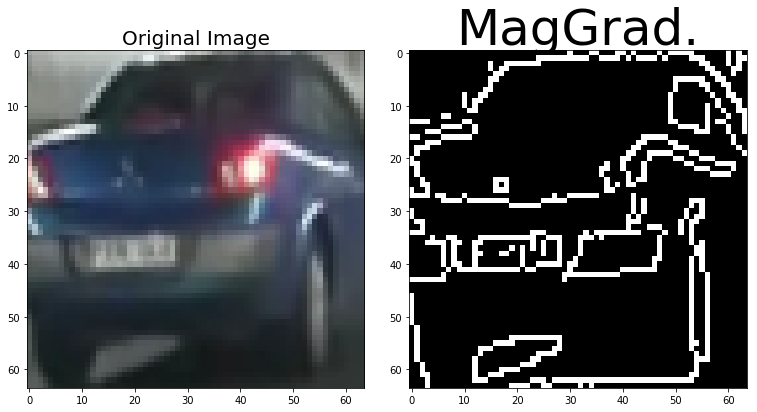

In [12]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobel = np.absolute(gradmag)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

ind = np.random.randint(0, len(cars))
# Read in the image
image = cv2.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define our parameters for Canny and run it
low_threshold = 10
high_threshold = 185
edges = cv2.Canny(gray, low_threshold, high_threshold)

#mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 150))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(edges, cmap='gray')
ax2.set_title('MagGrad.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print('done')

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

print('done')

done


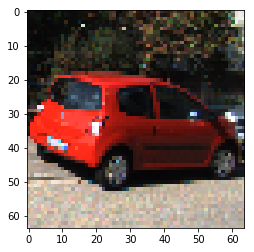

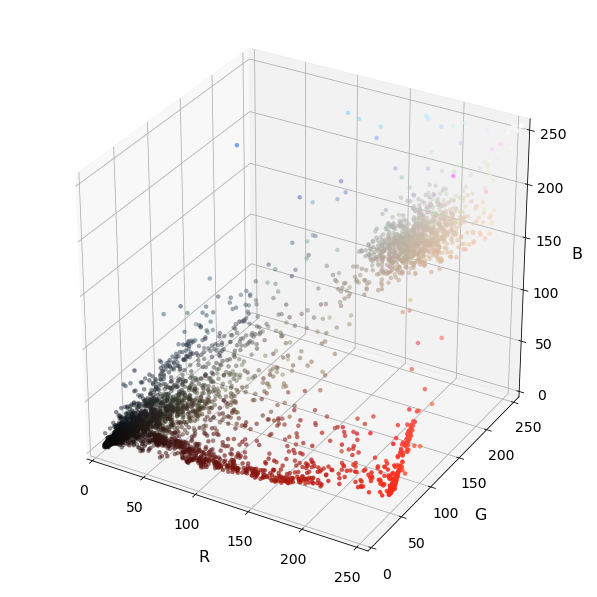

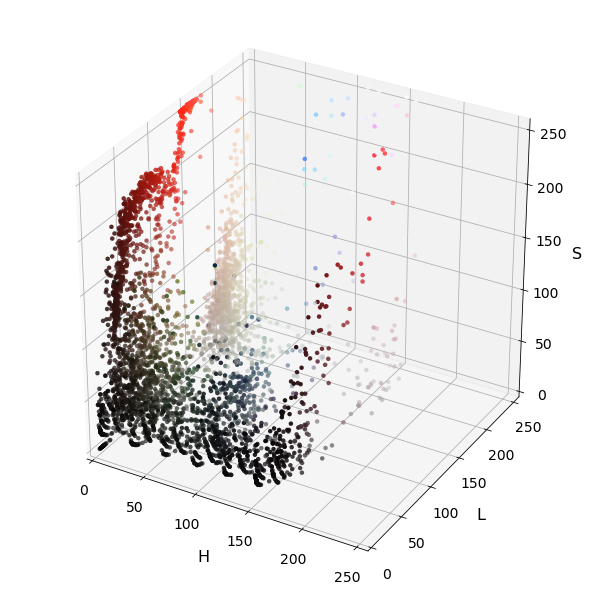

done


In [14]:
# Read a color image
ind = np.random.randint(0, len(cars))
# Read in the image
img = cv2.imread(cars[ind])
#image = mpimg.imread('cutout1.jpg')
#img = img.astype(np.float32)/255

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HLS"))
plt.show()

print('done')

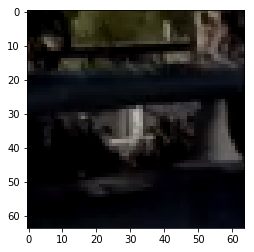

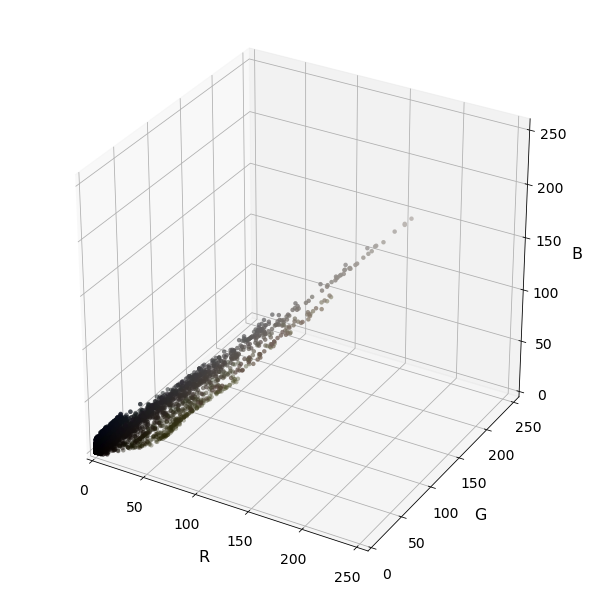

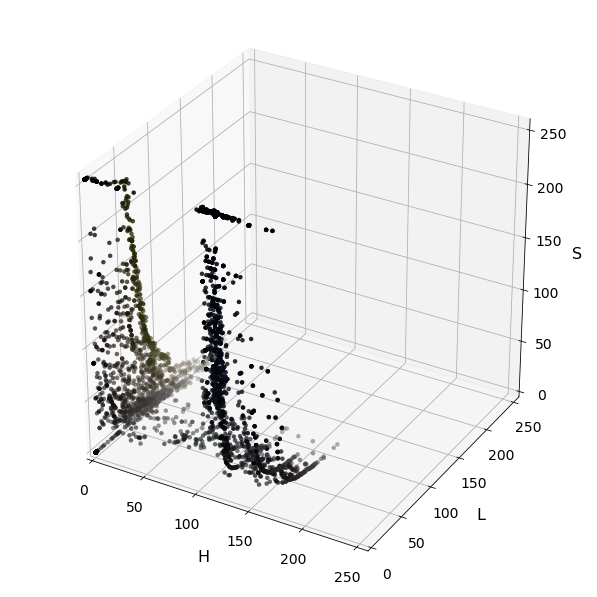

done


In [15]:
# Read a color image
ind = np.random.randint(0, len(notcars))
# Read in the image
img = cv2.imread(notcars[ind])

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HLS"))
plt.show()

print('done')

done


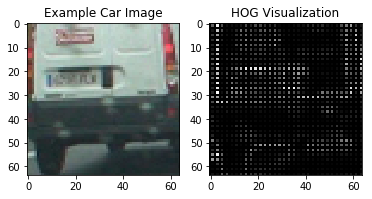

In [55]:
def test_get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
hog_features, hog_image = test_get_hog_features(gray, orient=11, 
                        pix_per_cell=2, cell_per_block=2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

print('done')

## Normalize the data

It´s important to normalize the data so different features are scaled into the same value range.

Python's sklearn package provides you with the StandardScaler() method to accomplish this task.

## Build the classifier

Choose and train a classifier: linear SVM, try others.
* Create balanced labeled data sets, cars and non-cars: use duplicate or extract more from video frames.
* Divide the data into training and test sets: shuffling randomly.
* SVM works well with HOG, but we can use a combination: Decision Trees, Neural networks..

Training works like this:
* Prepare the training set.
* Extract features from the training set.
* Supply the features vector to the training algorithm with the corresponding labels.

Verify with the Test set.

### Color Classify

In [4]:
def get_feature_image(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32), bin_channel='ALL'):
    if bin_channel == 'ALL':
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))
    else:
        color = cv2.resize(img[:,:,bin_channel], size).ravel()
        return np.hstack(color)

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256), hist_channel='ALL'):
    if hist_channel == 'ALL':
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else:
        # Compute the histogram of the color channels separately
        hist = np.histogram(img[:,:,hist_channel], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate(hist)
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

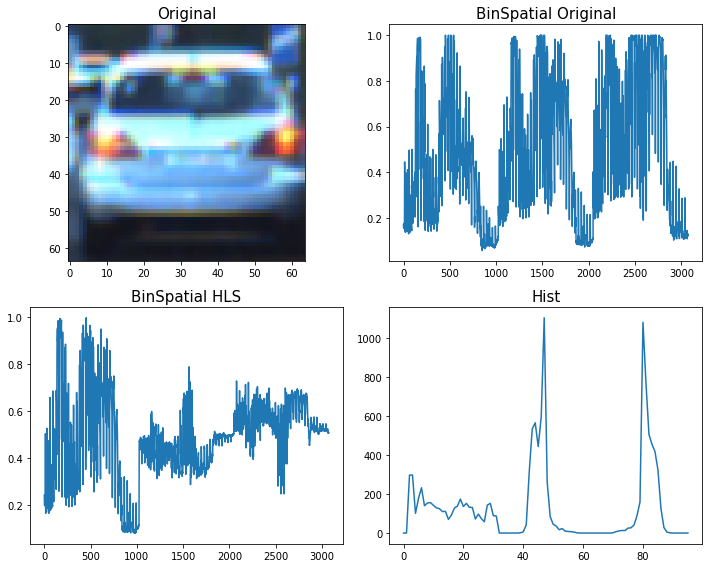

In [57]:
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind]) # Natively, matplotlib only supports PNG images
#image = cv2.imread(cars[ind])
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(10, 8))
ax1[0].imshow(image)
ax1[0].set_title('Original', fontsize=15)
ax1[1].plot(bin_spatial(image))
ax1[1].set_title('BinSpatial Original', fontsize=15)
ax2[0].plot(bin_spatial(feature_image))
ax2[0].set_title('BinSpatial HLS', fontsize=15)
ax2[1].plot(color_hist(feature_image,  bins_range=(0.0, 1.0)))
ax2[1].set_title('Hist', fontsize=15)
f.tight_layout()
plt.show()

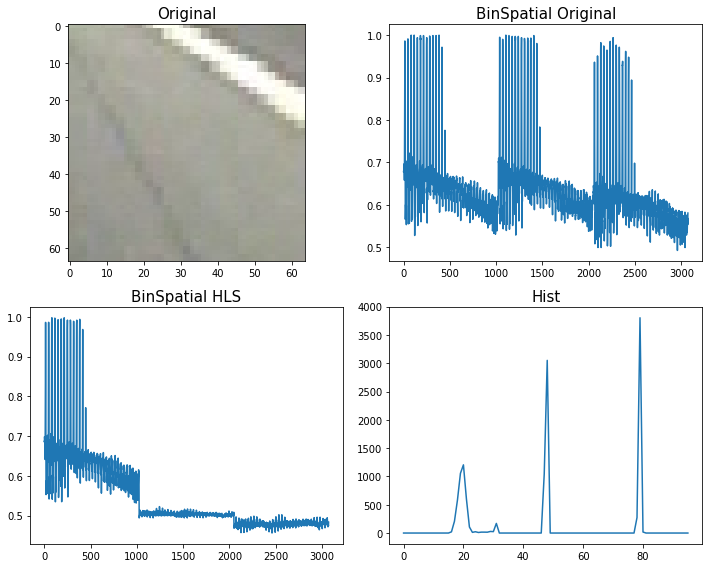

In [58]:
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
#image = cv2.imread(cars[ind])
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(10, 8))
ax1[0].imshow(image)
ax1[0].set_title('Original', fontsize=15)
ax1[1].plot(bin_spatial(image))
ax1[1].set_title('BinSpatial Original', fontsize=15)
ax2[0].plot(bin_spatial(feature_image))
ax2[0].set_title('BinSpatial HLS', fontsize=15)
ax2[1].plot(color_hist(feature_image, bins_range=(0.0, 1.0)))
ax2[1].set_title('Hist', fontsize=15)
f.tight_layout()
plt.show()

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def test_extract_color_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = get_feature_image(image, color_space)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

spatial = 32
histbin = 32
color_space = 'HLS'

print('Extracting features')
t = time.time()
car_features = test_extract_color_features(cars[:500], color_space=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = test_extract_color_features(notcars[:500], color_space=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print('Car features:', len(car_features))
print('Not car features:', len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:', spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

print('Training classifier')
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('done')

Extracting features
2.29 Seconds to extract HOG features...
Car features: 500
Not car features: 500
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
Training classifier
1.1 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00298 Seconds to predict 10 labels with SVC
done


### HOG Classify

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('done')

done


In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def test_extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

print('Extracting features')
t = time.time()
car_features = test_extract_hog_features(cars[:500], color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = test_extract_hog_features(notcars[:500], color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print('Car features:', len(car_features))
print('Not car features:', len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient,'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

print('Training classifier')
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('done')

Extracting features
7.14 Seconds to extract HOG features...
Car features: 500
Not car features: 500
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
Training classifier
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
0.00292 Seconds to predict 10 labels with SVC
done


## Color & HOG features combined

In [11]:
def get_feature_image(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_features_img(img, colorspaces=('RGB', 'YCrCb'), spatial_size=(32, 32), bin_channel='ALL',
                        hist_bins=32, hist_range=(0, 256), hist_channel='ALL',
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = get_feature_image(img, colorspaces[0])
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size, bin_channel=bin_channel)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, hist_channel=hist_channel)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        feature_image = get_feature_image(img, colorspaces[1])
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_list(imgs, colorspaces=('RGB', 'YCrCb'), spatial_size=(32, 32), bin_channel='ALL',
                        hist_bins=32, hist_range=(0, 256), hist_channel='ALL',
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file) # Natively, matplotlib only supports PNG images
        img_features = extract_features_img(image, colorspaces, spatial_size, bin_channel,
                        hist_bins, hist_range, hist_channel,
                        orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(img_features)

    # Return list of feature vectors
    return features

print('done')

done


In [13]:
### Tweak these parameters and see how the results change.
spatial_size = (32,32)
bin_channel = 'ALL'
hist_bins = 32
hist_channel = 'ALL'
colorspaces = ('HLS', 'YCrCb')# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hist_range=(0.0, 1.0)# Natively, matplotlib only supports PNG images
spatial_feat=False
hist_feat=False
hog_feat=True

t = time.time()
car_features = extract_features_list(cars[:500], colorspaces=colorspaces, spatial_size=spatial_size, bin_channel=bin_channel,
                        hist_bins=hist_bins, hist_range=hist_range, hist_channel=hist_channel,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_list(notcars[:500], colorspaces=colorspaces, spatial_size=spatial_size, bin_channel=bin_channel,
                        hist_bins=hist_bins, hist_range=hist_range, hist_channel=hist_channel,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print('Car features:', len(car_features))
print('Not car features:', len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler(copy=False).fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', orient,'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('done')

8.96 Seconds to extract HOG features...
Car features: 500
Not car features: 500
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
0.34 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [ 1.  1.  1.  0.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  0.  1.  1.  1.]
0.00337 Seconds to predict 10 labels with SVC
done


In [14]:
# Dump the trained LinearSVC with Pickle
svc_pkl_filename = 'mynotebooklinearsvc.p'
# Open the file to save as pkl file
svc_pkl = open(svc_pkl_filename, 'wb')
pickle.dump(svc, svc_pkl)
# Close the pickle instances
svc_pkl.close()

try:
    with open(svc_pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file', svc_pkl_filename)
        pickle.dump(
        {
            'svc': svc,
            'scaler': X_scaler,
            # Features parameters
            'spatial_size':spatial_size,
            'bin_channel':bin_channel,
            'hist_bins':hist_bins,
            'hist_channel':hist_channel,
            'colorspaces':colorspaces,
            'orient':orient,
            'pix_per_cell':pix_per_cell,
            'cell_per_block':cell_per_block,
            'hog_channel':hog_channel,
            'hist_range':hist_range,
            'spatial_feat':spatial_feat,
            'hist_feat':hist_feat,
            'hog_feat':hog_feat
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', svc_pkl_filename, ':', e)

print('done')

Saving to pickle file mynotebooklinearsvc.p
done


## Sliding window technique

Sliding window technique: multi-scale windows, different tiling schemes, minimize the number of search windows.

* decide what size window you want to search.
* where in the image you want to start and stop your search.
* how much you want windows to overlap.

In [15]:
# load a pre-trained svc model from a serialized (pickle) file
print('Loading classifier')
with open("mylinearsvc.p", "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    # get attributes of our svc object
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]

    spatial_size = dist_pickle['spatial_size']
    bin_channel = dist_pickle['bin_channel']
    hist_bins = dist_pickle['hist_bins']
    hist_channel = dist_pickle['hist_channel']
    colorspaces = dist_pickle['colorspaces']
    orient = dist_pickle['orient']
    pix_per_cell = dist_pickle['pix_per_cell']
    cell_per_block = dist_pickle['cell_per_block']
    hog_channel = dist_pickle['hog_channel']
    hist_range = dist_pickle['hist_range']
    spatial_feat = dist_pickle['spatial_feat']
    hist_feat = dist_pickle['hist_feat']
    hog_feat = dist_pickle['hog_feat']

print('Spatial feat:', spatial_feat, ', chn:', bin_channel)
print('Hist feat: ', hist_feat, ', chn:', hist_channel)
print('HOG feat:', hog_feat, ', chn:', hog_channel)
print('Colorspaces:', colorspaces)

print('done')

Loading classifier
Reading pickle
Spatial feat: False , chn: ALL
Hist feat:  False , chn: ALL
HOG feat: True , chn: ALL
Colorspaces: ('HLS', 'YCrCb')
done


In [16]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(imgshape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = imgshape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = imgshape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print('done')

done


done


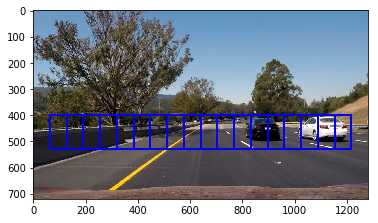

In [17]:
image = mpimg.imread('test_images/test6.jpg')

windows = slide_window(image.shape, x_start_stop=[64, image.shape[1]-64], y_start_stop=[400, 528], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

print('done')

done


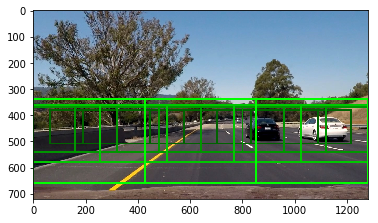

In [18]:
image = mpimg.imread('test_images/test6.jpg')

## Multi scale windows
windows1 = slide_window(image.shape, x_start_stop=[64, image.shape[1]-64], y_start_stop=[380, 528], 
                    xy_window=(128, 128), xy_overlap=(0, 0))

windows2 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[370, 600], 
                    xy_window=(160, 170), xy_overlap=(0, 0))

windows3 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[360, None],
                    xy_window=(256, 220), xy_overlap=(0, 0))

windows4 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[340, image.shape[0]], 
                    xy_window=(426, 320), xy_overlap=(0, 0))


window_img = draw_boxes(image, windows1, color=(0, 100, 0), thick=6)
window_img = draw_boxes(window_img, windows2, color=(0, 150, 0), thick=6)
window_img = draw_boxes(window_img, windows3, color=(0, 200, 0), thick=6)
window_img = draw_boxes(window_img, windows4, color=(0, 255, 0), thick=6)

plt.imshow(window_img)

print('done')

done


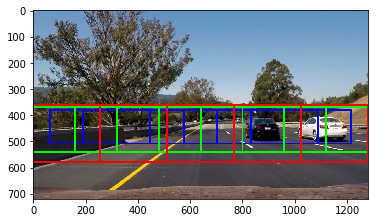

In [19]:
image = mpimg.imread('test_images/test6.jpg')

## Multi scale windows
windows21 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[400, 528], 
                    xy_window=(128, 64), xy_overlap=(0.5, 0))

windows22 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[370, 600], 
                    xy_window=(155, 180), xy_overlap=(0.2, 0))

windows23 = slide_window(image.shape, x_start_stop=[None, None], y_start_stop=[340, None],
                    xy_window=(232, 200), xy_overlap=(0.25, 0.5))


window_img = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, windows2, color=(0, 255, 0), thick=6)
window_img = draw_boxes(window_img, windows3, color=(255, 0, 0), thick=6)

plt.imshow(window_img)

print('done')

### Windows search

In [20]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler,
                    colorspaces, spatial_size, bin_channel,
                    hist_bins, hist_range, hist_channel,
                    orient, pix_per_cell, cell_per_block, hog_channel,
                    spatial_feat, hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    img = img.astype(np.float32)/255 # It´s a JPG
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features_img(test_img, colorspaces, spatial_size, bin_channel,
                                        hist_bins, hist_range, hist_channel,
                                        orient, pix_per_cell, cell_per_block, hog_channel,
                                        spatial_feat, hist_feat, hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print('done')

done


done


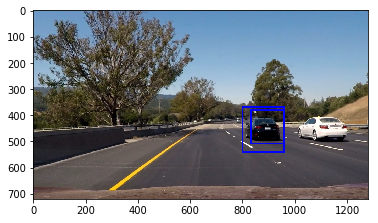

In [21]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

windows = windows1 + windows2 + windows3 + windows4

hot_windows = search_windows(image, windows, svc, X_scaler, 
                                colorspaces, spatial_size, bin_channel,
                                hist_bins, hist_range, hist_channel,
                                orient, pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

plt.imshow(window_img)

print('done')

done


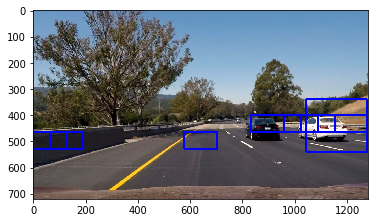

In [23]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

windows = windows21 + windows22 + windows23

hot_windows = search_windows(image, windows, svc, X_scaler, 
                                colorspaces, spatial_size, bin_channel,
                                hist_bins, hist_range, hist_channel,
                                orient, pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

plt.imshow(window_img)

print('done')

### Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once.
The find_cars only has to extract hog features once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).

In [26]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                colorspaces, spatial_size, bin_channel,
                hist_bins, hist_range, hist_channel,
                orient, pix_per_cell, cell_per_block, hog_channel,
                spatial_feat, hist_feat, hog_feat):

    window_list = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    color_feature_img = get_feature_image(img_tosearch, colorspaces[0])
    hog_feature_img = get_feature_image(img_tosearch, colorspaces[1])
    
    if scale != 1:
        imshape = color_feature_img.shape
        color_feature_img = cv2.resize(color_feature_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        hog_feature_img = cv2.resize(hog_feature_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (color_feature_img[:,:,0].shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (color_feature_img[:,:,0].shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog1 = get_hog_features(hog_feature_img[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(hog_feature_img[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(hog_feature_img[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            hog1 = get_hog_features(hog_feature_img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            features = []
            # Extract HOG for this patch
            if hog_feat == True:
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    features.append(np.hstack((hog_feat1, hog_feat2, hog_feat3)))
                else:
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    features.append(np.hstack((hog_feat1)))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(color_feature_img[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat == True:
                features.append(bin_spatial(subimg, size=spatial_size, bin_channel=bin_channel))
            if hist_feat == True:
                features.append(color_hist(subimg, nbins=hist_bins, bins_range=hist_range, hist_channel=hist_channel))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(features).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Append window position to list
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))

    return window_list

print('done')

done


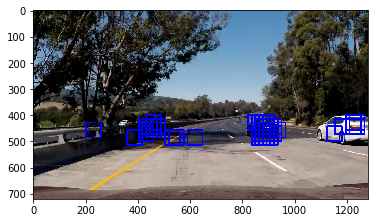

In [27]:
def test_find_cars(imgname, ystart=400, ystop=600, scale=1.0):
    image = mpimg.imread('test_images/'+imgname)
    draw_image = np.copy(image)

    #ystart = 350
    #ystop = 550
    #scale = 1.7

    windows = find_cars(image, ystart, ystop, scale, svc, X_scaler,
                            colorspaces, spatial_size, bin_channel,
                            hist_bins, hist_range, hist_channel,
                            orient, pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)

    out_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
    plt.imshow(out_img)
    plt.show()

interact(test_find_cars, imgname=listdir('test_images'), ystart=(0,720), ystop=(0, 720), scale=(0.0,10.0))
print('done')

In [28]:
find_cars_limits = []
### Windows of 64 in scale 1.0
find_cars_limits.append([400, 464, 1.0])
find_cars_limits.append([416, 480, 1.0])
### Windows of 96 in scale 1.5
find_cars_limits.append([400, 496, 1.5])
find_cars_limits.append([448, 544, 1.5])
### Windows of 128 in scale 2.0
find_cars_limits.append([400, 528, 2.0])
find_cars_limits.append([462, 590, 2.0])
### Windows of 64 in scale 3.0
find_cars_limits.append([400, 592, 3.0])
find_cars_limits.append([496, 692, 3.0])

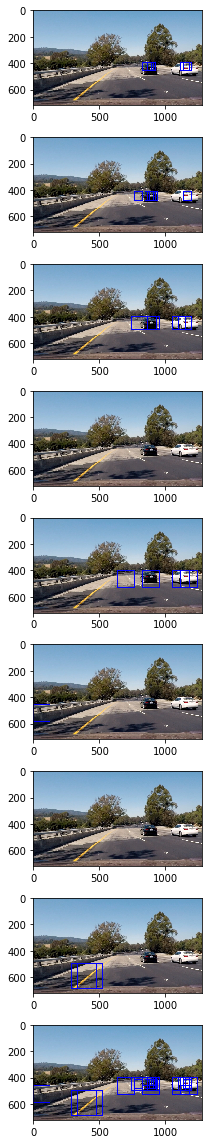

done


In [35]:
image = mpimg.imread('test_images/test4.jpg')

windows = []
for l in find_cars_limits:
    ystart = l[0]
    ystop = l[1]
    scale = l[2]
    w = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                    colorspaces, spatial_size, bin_channel,
                    hist_bins, hist_range, hist_channel,
                    orient, pix_per_cell, cell_per_block, hog_channel,
                    spatial_feat, hist_feat, hog_feat)
    windows.append(w)

hot_windows = sum(windows, [])

f, (ax) = plt.subplots(len(windows)+1, 1, figsize=(20, 16))
ax = ax.ravel()
for i, w in enumerate(windows):
    ax[i].imshow(draw_boxes(image, w, color=(0, 0, 255), thick=6))

ax[len(windows)].imshow(draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6))

f.tight_layout()
plt.show()

print('done')

## Multiple detections and false positives

When having a working pipeline: implement tracking to follow, detect vehicles and reject spurious detections.

done


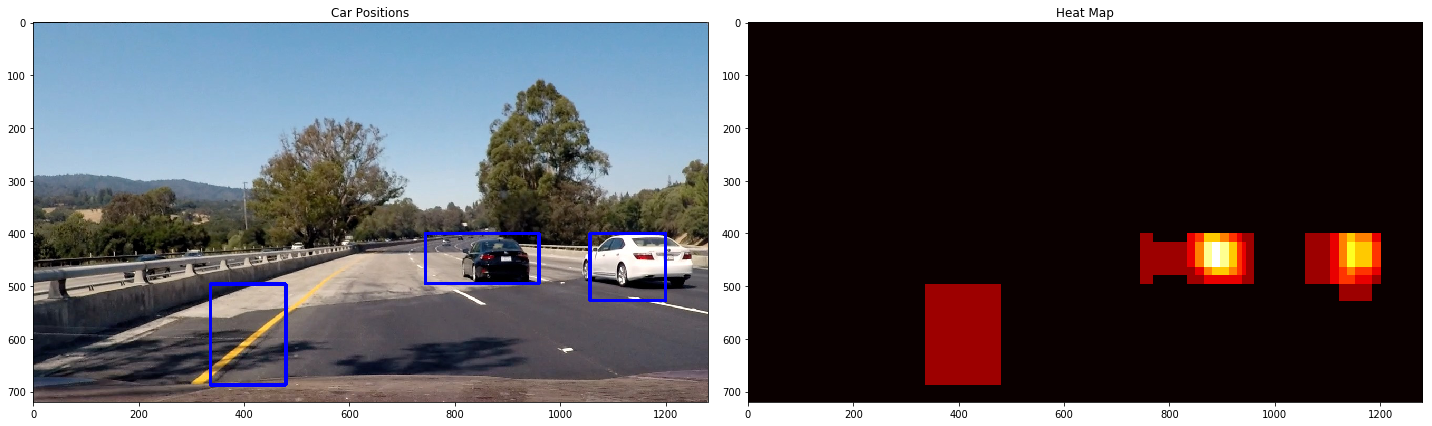

In [36]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    # Return the image
    return bboxes

def draw_labeled_bboxes(img, bboxes):    
    # Iterate through all detected cars
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), get_labeled_bboxes(labels))


fig = plt.figure(figsize=(20, 16))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

print('done')

* Sliding window search
* Overlapping: assign the position of the detection to the centroid of the overlapping windows.
* False positives: determine which detections appear in one frame but not the next.
* High confidence detection: record how the centroid is moving from frame to frame and estimate where it will appear.

In [37]:
## Use a frame to frame detection. Paint high confidence detections
class CarDetection():
    def __init__(self, votes_threshold=5):
        # These list MUST have same length
        self.bboxes = []
        self.centroids = []
        self.votes = []
        self.votes_threshold = votes_threshold

    def add_bboxes(self, bboxes, threshold=10):
        prev_bboxes = self.bboxes
        prev_centroids = self.centroids
        prev_votes = self.votes
        self.bboxes = []
        self.centroids = []
        self.votes = []
        prev_found = []
        # Add new bboxes with vote 1
        for bbox in bboxes:
            centroid = (bbox[0][0]+(bbox[1][0]/2), bbox[0][1]+(bbox[1][1]/2))
            self.centroids.append(centroid)
            self.bboxes.append(bbox)
            self.votes.append(1)

        # Check matches with  the old ones
        for ip, prev_centroid in enumerate(prev_centroids):
            match = False
            for ic, centroid in enumerate(self.centroids):
                if sqrt( (centroid[0]-prev_centroid[0])**2 + (centroid[1]-prev_centroid[1])**2 ) <= threshold:
                    # We have a match
                    match = True
                    # Promote
                    self.votes[ic] = prev_votes[ip] + 1
                    # Interpolate
                    """
                    self.bboxes[ic] = \
                        ( ( (self.bboxes[ic][0][0]+prev_bboxes[ip][0][0])//2, (self.bboxes[ic][0][1]+prev_bboxes[ip][0][1])//2),
                        ( (self.bboxes[ic][1][0]+prev_bboxes[ip][1][0])//2, (self.bboxes[ic][1][1]+prev_bboxes[ip][1][1])/2) )
                    """
                    break
            if match == False:
                # No match. Add but downvote
                vote = prev_votes[ip]-1
                if vote > 0:
                    self.centroids.append(prev_centroid)
                    self.bboxes.append(prev_bboxes[ip])
                    self.votes.append(prev_votes[ip]-1)

    def get_detections(self):
        detections = []
        for i, vote in enumerate(self.votes):
            if vote > self.votes_threshold:
                detections.append(self.bboxes[i])
        return detections

In [42]:
## Use a frame to frame detection. Paint high confidence detections
car_detection = CarDetection(5)

def process_image(image):
    windows = []
    for l in find_cars_limits:
        ystart = l[0]
        ystop = l[1]
        scale = l[2]
        windows.append(find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                colorspaces, spatial_size, bin_channel,
                                hist_bins, hist_range, hist_channel,
                                orient, pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat))

    hot_windows = sum(windows, [])
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    bboxes = get_labeled_bboxes(labels)
    
    # Update detections
    car_detection.add_bboxes(bboxes, threshold=30)
    
    draw_img = draw_labeled_bboxes(np.copy(image), car_detection.get_detections())

    return draw_img

## NOTE: The following video is just a subclip of the total video

In [43]:
videoname = 'project_video.mp4'
video_output = 'result_notebook.'+ videoname
clip1 = VideoFileClip(videoname).subclip(10.0, 15.0)
process_clip = clip1.fl_image(process_image)
%time process_clip.write_videofile(video_output, audio=False)

print('done')

[MoviePy] >>>> Building video result_notebook.project_video.mp4
[MoviePy] Writing video result_notebook.project_video.mp4


 99%|█████████▉| 125/126 [01:18<00:00,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_notebook.project_video.mp4 

CPU times: user 1min 26s, sys: 310 ms, total: 1min 27s
Wall time: 1min 20s
done


In [44]:
HTML('<video width=\"960\" height=\"540\" controls><source src=\"{0}\"></video>'.format(video_output))

## NOTE: The following video is the total result video

In [45]:
HTML('<video width=\"960\" height=\"540\" controls><source src=\"{0}\"></video>'.format('result.project_video.mp4'))